In [1]:
from datetime import timedelta , datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
Country='Russia' # Input Country name

data = pd.read_csv('time_series_covid19_confirmed_global (7).csv')
data_2 = pd.read_csv('time_series_covid19_recovered_global (5).csv')
data_3 = pd.read_csv('time_series_covid19_deaths_global (6).csv')

# Infector
I_cml = data[data['Country/Region'] == Country].to_numpy()[0][-141:-20]
# Recover
recovered_1 = data_2[data_2['Country/Region'] == Country].to_numpy()[0][-141:-20]
# Death
death = data_3[data_3['Country/Region'] == Country].to_numpy()[0][-141:-20]
# Population
population =  145500000 # Input population in Country

In [3]:
########## data preprocess ##########
I = 0.6 * (I_cml - recovered_1 - death)
A = 0.4 * (I_cml - recovered_1 - death)
R_1 = 0.4 * (recovered_1)
R_2 = 1.5 * (R_1)
D = death
alpha = 0.6

n = np.array([population] * len(I), dtype=np.float64)
    
S = n - I - R_1 - R_2 - D - A
eta = (D[1:] - D[:-1]) / I[:-1] # death rate
gamma_1 = 1 + (eta) + alpha * ((S[:-1] - S[1:]) / I[:-1]) - I[1:] / I[:-1] # Recovery rate for symptom
gamma_2 = 1 + (1 - alpha) * ((S[:-1] - S[1:]) / A[:-1]) - A[1:] / A[:-1] # Recovery rate for asymptom
beta = ((S[:-1] - S[1:]) * (S[:-1] + I[:-1] + A[:-1])) / ((S[:-1]) * (I[:-1] + 0.5 * A[:-1])) # Infected rate
R0 = beta * (alpha / (gamma_1 + eta) + ((1 - alpha) * 0.5) / gamma_2) # Basic reproduction number

In [4]:
I_ori = np.zeros(121)
I_ori = I
A_ori = np.zeros(121)
A_ori = A
R_ori_1 = np.zeros(121)
R_ori_1 = R_1
R_ori_2 = np.zeros(121)
R_ori_2 = R_2
R_ori = np.zeros(121)
R_ori = R_1 + R_2
D_ori = np.zeros(121)
D_ori = D

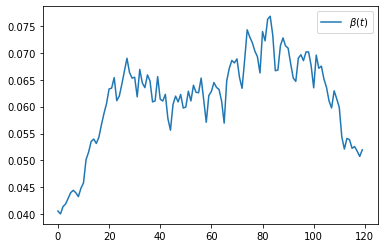

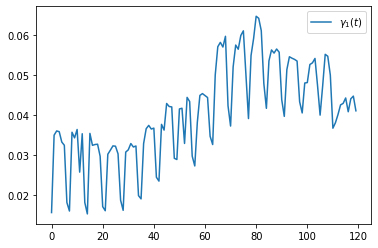

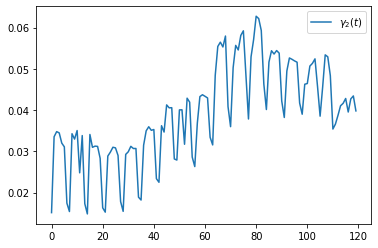

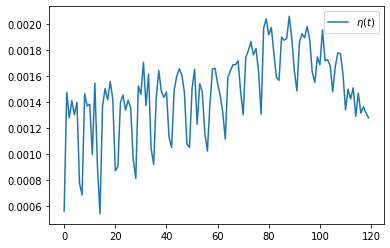

In [5]:
##### Plot the training and testing results #####
plt.figure(1)
plt.plot(beta, label = r'$\beta (t)$')
plt.legend()

plt.figure(2)
plt.plot(gamma_1, label = r'$\gamma_1 (t)$')
plt.legend()

plt.figure(3)
plt.plot(gamma_2, label = r'$\gamma_2 (t)$')
plt.legend()

plt.figure(4)
plt.plot(eta, label = r'$\eta (t)$')
plt.legend()

In [6]:
def data_split(data,start,T):
    return data[start:start+T]

In [7]:
##### Orders of three kinds of FIR model #####
orders_beta = 18
orders_gamma_1 = 11
orders_gamma_2 = 11
orders_eta = 5
orders_R0 = 8

##### starting day #####
start_beta = 0
start_gamma = 0
start_eta = 0
start_R0 = 0

In [8]:
##### The total prediction date #####
Z=120

In [9]:
def cut_origin_train_data(J,T,data):
    O_data = np.zeros((T-J,J+1))
    for i in range (T-J):
        y_1 = data_split(data,0+i,J) #Cut the first training data(length(J))
        y_1 = np.append(y_1,1)
        y_1 = y_1[::-1]
        O_data[i] = y_1
    return(O_data)

def find_prediction_data(J,T,y_train,O_data):
    A_first = np.zeros((J+1,J+1))
    A_final = np.zeros((J+1,J+1))
    X = np.zeros(J+1)
    H = np.zeros(J+1)
    I = np.identity(J+1)
    B_first = np.zeros(J+1)
    data_hat_final = np.zeros(120-J)
    data_hat_predict = np.zeros((120-T))
    for k in range (120-T):
        A_first[0][0] = T-J
        data = y_train
        for i in range (1,J+1):
            for j in range (1,J+1):
                c = 0
                for t in range (J,T):
                    c += ((data[t-i]) * (data[t-j]))
                    A_first[i][j] = c
            b = 0
            c = 0
            for t in range (J,T):
                c += data[t-i]
                A_first[0][i] = c
                A_first[i][0] = c          
                b += ((data[t]) * (data[t-i]))
                B_first[i] = b
        b = 0
        for t in range (J,T):
            b += (data[t])
            B_first[0] = b
        B_first = B_first.T
        alpha = 0
        A_2 = A_first + (alpha) * I #(alpha*I+A)
        A_final = np.linalg.inv(A_2)
        X = np.matmul(A_final,B_first)
        for i in range (1,J+1):
            H[i] = data[T-i]
        H[0] = 1
        H = H.T
        data_hat_predict[k] = np.matmul(X,H)
        prediction_data = data_hat_predict[k]
        y_train = np.append(y_train,prediction_data) # Put prediction data into training data 
        T = len(y_train)
        if k == 0:
            O_data = np.dot(O_data,X)
    t = 0
    for i in range (120-J):
        if i < 100 - J  :
            data_hat_final[i] = O_data[i]
        else :
            data_hat_final[i] = data_hat_predict[t]
            t = t + 1
    return(data_hat_predict,data_hat_final)

#  <font color = green>Beta</font>

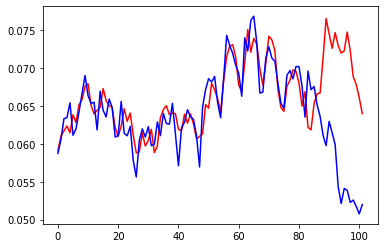

In [10]:
##### Order of FIR model #####
J = orders_beta

##### Size of the interval #####
T = 100

O_beta = cut_origin_train_data(J,T,beta)

beta_ori = beta
beta_train = beta # Training data of beta

beta_predict,beta_hat = find_prediction_data(J,T,beta_train,O_beta)

plt.plot(beta_hat,'r')
plt.plot(beta_ori[J:],'b')

# <font color = green>Gamma_1</font>

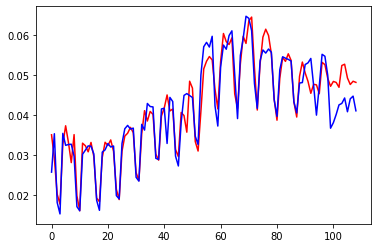

In [11]:
##### Order of FIR model #####
J = orders_gamma_1

##### Size of the interval #####
T = 100

O_gamma_1 = cut_origin_train_data(J,T,gamma_1)

gamma_ori_1 = gamma_1
gamma_train_1 = gamma_1 # Training data of beta

gamma_predict_1,gamma_hat_1 = find_prediction_data(J,T,gamma_train_1,O_gamma_1)

plt.plot(gamma_hat_1,'r')
plt.plot(gamma_ori_1[J:],'b')

# <font color = green>Gamma_2</font>

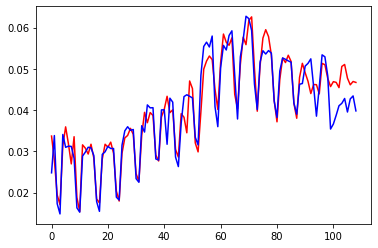

In [12]:
##### Order of FIR model #####
J = orders_gamma_2

##### Size of the interval #####
T = 100

O_gamma_2 = cut_origin_train_data(J,T,gamma_2)

gamma_ori_2 = gamma_2
gamma_train_2 = gamma_2 # Training data of beta

gamma_predict_2,gamma_hat_2 = find_prediction_data(J,T,gamma_train_2,O_gamma_2)

plt.plot(gamma_hat_2,'r')
plt.plot(gamma_ori_2[J:],'b')

# <font color = green>Eta</font>

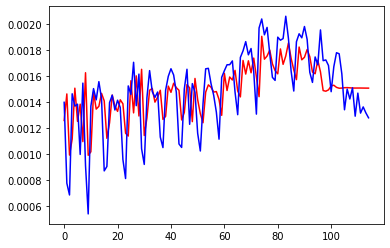

In [13]:
##### Order of FIR model #####
J = orders_eta

##### Size of the interval #####
T = 100

O_eta = cut_origin_train_data(J,T,eta)

eta_ori = eta
eta_train = eta # Training data of beta

eta_predict,eta_hat = find_prediction_data(J,T,eta_train,O_eta)

plt.plot(eta_hat,'r')
plt.plot(eta_ori[J:],'b')

# <font color = green>R0</font>

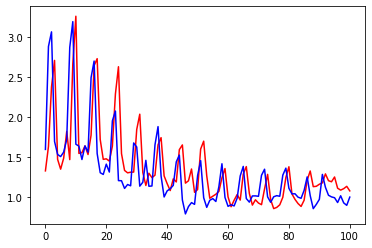

In [14]:
J = 19
R0 = np.zeros(len(beta_ori))
R0_hat = np.zeros(120-J)
for i in range (len(beta_ori)):
    R0[i] = beta_ori[i] * (alpha / (gamma_ori_1[i] + eta_ori[i]) + ((1 - alpha) * 0.5) / gamma_ori_2[i])
for i in range (120-J):
    R0_hat[i] = beta_hat[i] * (alpha / (gamma_hat_1[i] + eta_hat[i]) + ((1 - alpha) * 0.5) / gamma_hat_2[i])
plt.plot(R0_hat,'r')
plt.plot(R0[J:],'b')

# <font color = green>I  A R D</font>

In [15]:
alpha=0.6
J = 19
T = 100

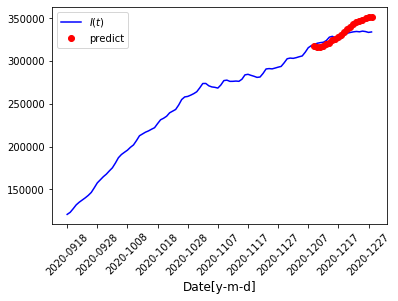

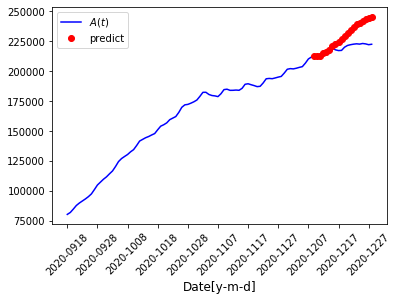

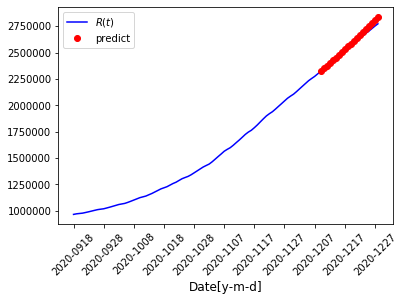

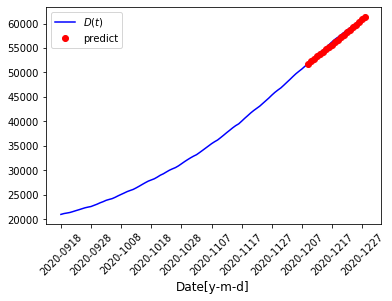

In [16]:
date = list(pd.to_datetime(data.columns[-141:-20]).strftime('%Y-%m%d'))
    
S_hat = np.zeros(120-J+1)
S_hat_2 = np.zeros(120-T+1)
I_hat = np.zeros(120-J+1)
I_hat_2 = np.zeros(120-T+1)
A_hat = np.zeros(120-J+1)
A_hat_2 = np.zeros(120-T+1)
R_hat = np.zeros(120-J+1)
R_hat_2 = np.zeros(120-T+1)
D_hat = np.zeros(120-J+1)
D_hat_2 = np.zeros(120-T+1)
t = 0
k = 0
for i in range (120-J+1):
    if i == 0:
        I_hat[i] = I_ori[J-1]
        A_hat[i] = A_ori[J-1]
        R_hat[i] = R_ori[J-1]
        D_hat[i] = D_ori[J-1]
        S_hat[i] = S[J-1]
    else :
        S_hat[i] = S_hat[i-1] - S_hat[i-1] * beta_hat[t] * ((I_hat[i-1] + 0.5 * A_hat[i-1]) / (S_hat[i-1] + I_hat[i-1] + A_hat[i-1]))
        I_hat[i] = I_hat[i-1] * (1 - gamma_hat_1[t] - eta_hat[t]) + alpha * S_hat[i-1] * beta_hat[t] * ((I_hat[i-1] + 0.5 * A_hat[i-1]) / (S_hat[i-1] + I_hat[i-1] + A_hat[i-1]))
        A_hat[i] = A_hat[i-1] * (1 - gamma_hat_2[t]) + (1 - alpha) * S_hat[i-1] * beta_hat[t] * ((I_hat[i-1] + 0.5 * A_hat[i-1]) / (S_hat[i-1] + I_hat[i-1] + A_hat[i-1]))
        R_hat[i] = R_hat[i-1] + (gamma_hat_1[t] * I_hat[i-1]) + (gamma_hat_2[t] * A_hat[i-1])
        D_hat[i] = D_hat[i-1] + (eta_hat[t] * I_hat[i-1])
        t = t + 1
for i in range (120-T+1):
    if i == 0:
        I_hat_2[i] = I_ori[T]
        A_hat_2[i] = A_ori[T]
        R_hat_2[i] = R_ori[T]
        D_hat_2[i] = D_ori[T]
        S_hat_2[i] = S[T]
    else:
        S_hat_2[i] = S_hat_2[i-1] - S_hat_2[i-1] * beta_predict[k] * ((I_hat_2[i-1] + 0.5 * A_hat_2[i-1]) / (S_hat_2[i-1] + I_hat_2[i-1] + A_hat_2[i-1]))
        I_hat_2[i] = I_hat_2[i-1] * (1 - gamma_predict_1[k] - eta_predict[k]) + alpha * S_hat_2[i-1] * beta_predict[k] * ((I_hat_2[i-1] + 0.5 * A_hat_2[i-1]) / (S_hat_2[i-1] + I_hat_2[i-1] + A_hat_2[i-1]))
        A_hat_2[i] = A_hat_2[i-1] * (1 - gamma_predict_2[k]) + (1 - alpha) * S_hat[i-1] * beta_predict[k] * ((I_hat_2[i-1] + 0.5 * A_hat_2[i-1]) / (S_hat_2[i-1] + I_hat_2[i-1] + A_hat_2[i-1]))
        R_hat_2[i] = R_hat_2[i-1] + (gamma_predict_1[k] * I_hat_2[i-1]) + (gamma_predict_2[k] * A_hat_2[i-1])
        D_hat_2[i] = D_hat_2[i-1] + (eta_predict[k] * I_hat_2[i-1])
        k = k + 1
I_hat[-(120-T+1):] = I_hat_2
A_hat[-(120-T+1):] = A_hat_2
R_hat[-(120-T+1):] = R_hat_2
D_hat[-(120-T+1):] = D_hat_2
plt.figure(1)
plt.plot(I_ori[J:],'b',label = r'$I(t)$')
plt.plot(range(T-J+1,len(I_hat)),I_hat[T-J+1:],'o', mec = 'r',mfc = 'r',label = r'predict')
plt.xticks(range(0,len(I_hat),10),date[5::10],rotation = 45)
plt.xlabel('Date[y-m-d]',fontsize = 12)
plt.legend()
plt.figure(2)
plt.plot(A_ori[J:],'b',label = r'$A(t)$')
plt.plot(range(T-J+1,len(A_hat)),A_hat[T-J+1:],'o', mec = 'r',mfc = 'r',label = r'predict')
plt.xticks(range(0,len(A_hat),10),date[5::10],rotation = 45)
plt.xlabel('Date[y-m-d]',fontsize = 12)
plt.legend()
plt.figure(3)
plt.plot(R_ori[J:],'b',label = r'$R(t)$')
plt.plot(range(T-J+1,len(R_hat)),R_hat[T-J+1:],'o', mec = 'r',mfc = 'r',label = r'predict')
plt.xticks(range(0,len(R_hat),10),date[5::10],rotation = 45)
plt.xlabel('Date[y-m-d]',fontsize = 12)
plt.legend()
plt.figure(4)
plt.plot(D_ori[J:],'b',label = r'$D(t)$')
plt.plot(range(T-J+1,len(D_hat)),D_hat[T-J+1:],'o', mec = 'r',mfc = 'r',label = r'predict')
plt.xticks(range(0,len(D_hat),10),date[5::10],rotation = 45)
plt.xlabel('Date[y-m-d]',fontsize = 12)
plt.legend()

# <font color = purple>Find The Effective Interval</font>

In [17]:
for i in range (20):
    if I_hat[-(20-i)] < 0.95 * I_ori[-(20-i)] or I_hat[-(20-i)] > 1.05 * I_ori[-(20-i)] :
        break
    if i == 19:
        i += 1
for i_1 in range (20):
    if I_hat[-(20-i_1)] < 0.9 * I_ori[-(20-i_1)] or I_hat[-(20-i_1)] > 1.1 * I_ori[-(20-i_1)] :
        break
    if i_1 == 19:
        i_1 += 1 
for i_2 in range (20):
    if I_hat[-(20-i_2)] < 0.8 * I_ori[-(20-i_2)] or I_hat[-(20-i_2)] > 1.2 * I_ori[-(20-i_2)] :
        break
    if i_2 == 19:
        i_2 += 1 

In [18]:
for j in range (20):
    if A_hat[-(20-j)] < 0.95 * A_ori[-(20-j)] or A_hat[-(20-j)] > 1.05 * A_ori[-(20-j)] :
        break
    if j == 19:
        j += 1
for j_1 in range (20):
    if A_hat[-(20-j_1)] < 0.9 * A_ori[-(20-j_1)] or A_hat[-(20-j_1)] > 1.1 * A_ori[-(20-j_1)] :
        break
    if j_1 == 19:
        j_1 += 1
for j_2 in range (20):
    if A_hat[-(20-j_2)] < 0.8 * A_ori[-(20-j_2)] or A_hat[-(20-j_2)] > 1.2 * A_ori[-(20-j_2)] :
        break
    if j_2 == 19:
        j_2 += 1

# <font color = purple>Plot Figures</font>

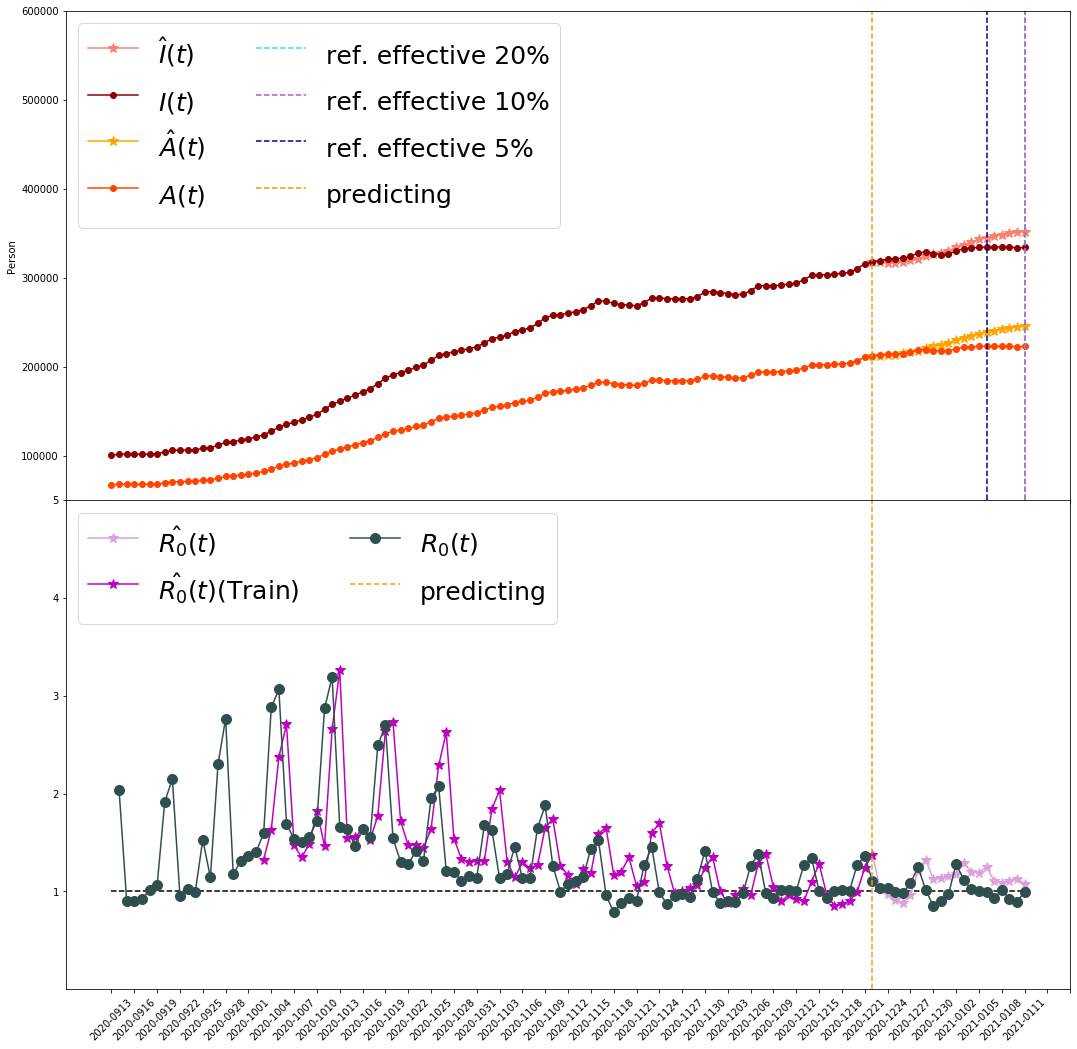

In [19]:
#------ show I,A and R0 graoh ------
plt.figure(figsize = (18,18))
#--- I,A graph ---
ax0 = plt.subplot(211)

plt.plot(range(len(I_ori) - 21 , len(I_ori)), I_hat[T-J:], '-*', color='salmon', label=r'$\hat{I}(t)$', markersize=10)
plt.plot(range(len(I_ori)), I_ori, '-o', color='darkred', label=r'$I(t)$')

plt.plot(range(len(A_ori) - 21 , len(A_ori)), A_hat[T-J:], '-*', color='orange', label=r'$\hat{A}(t)$', markersize=10)
plt.plot(range(len(A_ori)), A, '-o', color='orangered', label=r'$A(t)$')
#--- format ---
plt.axvline(len(I_ori) - 1, 0, 2500000, ls='--', c='turquoise', label='ref. effective 20%')
plt.axvline(len(I_ori) - 1, 0, 2500000, ls='--', c='mediumorchid', label='ref. effective 10%')
plt.axvline(len(I_ori) - 6, 0, 80000, ls='--', c='darkblue', label='ref. effective 5%')
plt.axvline(len(I_ori) - 21, 0, 200000, ls='--', c='goldenrod', label='predicting')
plt.xlabel('Day')
plt.ylabel('Person')
plt.ylim(50000, 600000)
plt.xticks([])
plt.legend(loc='upper left', fontsize='xx-large', ncol=2, handleheight=2.4, labelspacing=0.05, prop={'size': 25})
#--- R0 graph ---
ax1 = plt.subplot(212, sharex=ax0)

plt.xticks(range(0, len(I_ori) + 21,3), date[0::3], rotation=45)
plt.plot(range(len(A_ori) - 21 , len(A_ori)), R0_hat[-21:], '-*', color='plum', label=r'$\hat{R_{0}}(t)$', markersize=10)
plt.plot(range(len(A_ori) - len(R0_hat) , len(A_ori)-20), R0_hat[:-20], '-*', color='m', label=r'$\hat{R_{0}}(t)$(Train)', markersize=10)
plt.plot(range(1, len(A_ori)), R0, '-o', color='darkslategray', label=r'$R_{0}(t)$', markersize=10)

#--- format ---
plt.hlines(1,0, len(R0), color='black', ls='--')
plt.axvline(len(I_ori) - 21, 0, 2500000, ls='--', c='goldenrod', label='predicting')
plt.yticks([1,2,3,4,5])
plt.ylim(0,5)
plt.subplots_adjust(hspace=.0)
plt.legend(loc='upper left', fontsize='xx-large', ncol=2, handleheight=2.4, labelspacing=0.05, prop={'size': 25})

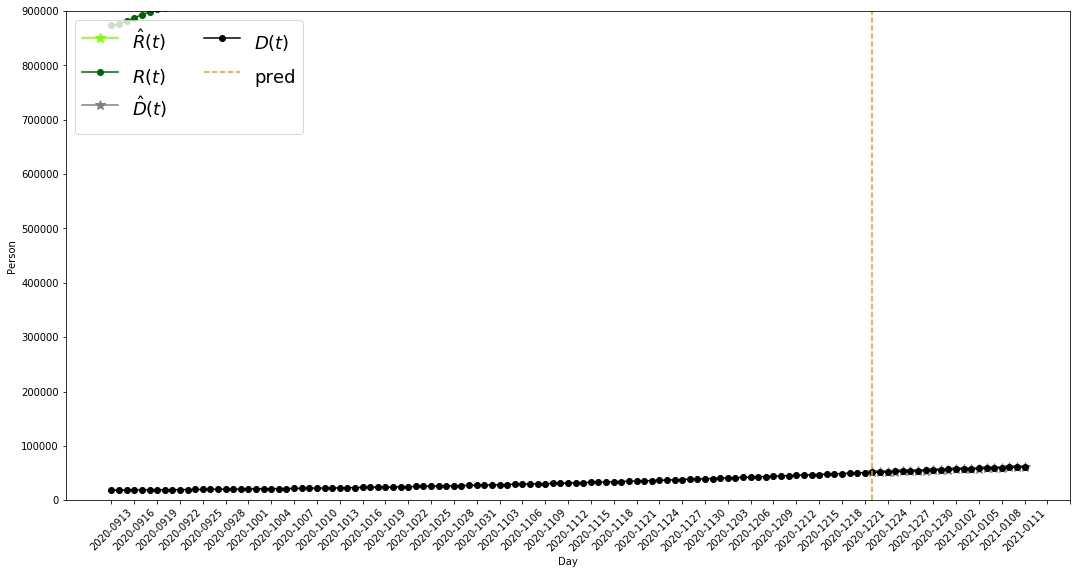

In [20]:
plt.figure(figsize = (18,9))

plt.xticks(range(0 , len(I_ori) + 21 , 3) , date[0::3] , rotation = 45)

plt.plot(range(len(R_ori) - 21 , len(R_ori)) , R_hat[T-J:] , '-*' , color = 'chartreuse' , label = r'$\hat{R}(t)$',markersize = 10)
plt.plot(range(len(R_ori)) , R_ori , '-o' , color = 'darkgreen' , label = r'$R(t)$')

plt.plot(range(len(D_ori) - 21 , len(D_ori)) , D_hat[T-J:] , '-*' , color = 'gray' , label = r'$\hat{D}(t)$',markersize = 10)
plt.plot(range(len(D_ori)) , D_ori , '-o' , color = 'black' , label = r'$D(t)$')

plt.axvline(len(I_ori) - 21, 0 , 2500000 , ls = '--' , c = 'goldenrod' , label = 'pred')

plt.ylim(0 , 900000)

plt.xlabel('Day')
plt.ylabel('Person')
plt.legend(fontsize='xx-large',ncol=2, handleheight = 2.4 ,labelspacing=0.05,prop = {'size' : 18} , loc = 'upper left')

# <font color = purple>Parameters And Effective Intervals</font>

In [21]:
print('orders of beta    = ', orders_beta)
print('orders of gamma_1 = ', orders_gamma_1)
print('orders of gamma_2 = ', orders_gamma_2)
print('orders of eta     = ', orders_eta)
print()
print('effective interval of I(t) in  5%:' ,i, 'days')
print('effective interval of I(t) in 10%:' ,i_1, 'days')
print('effective interval of I(t) in 20%:' ,i_2, 'days')
print()
print('effective interval of A(t) in  5%:' ,j, 'days')
print('effective interval of A(t) in 10%:' ,j_1, 'days')
print('effective interval of A(t) in 20%:' ,j_2, 'days')

orders of beta    =  18
orders of gamma_1 =  11
orders of gamma_2 =  11
orders of eta     =  5

effective interval of I(t) in  5%: 18 days
effective interval of I(t) in 10%: 20 days
effective interval of I(t) in 20%: 20 days

effective interval of A(t) in  5%: 12 days
effective interval of A(t) in 10%: 18 days
effective interval of A(t) in 20%: 20 days
